In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
import sncosmo
import analyzeSN as ans
import opsimsummary as oss

In [37]:
from lsst.sims.catUtils.supernovae import SNObject
from lsst.sims.photUtils import BandpassDict

In [5]:
from varsim import BasePopulation, BasicSimulation, BaseModel

In [6]:
opsout = oss.OpSimOutput.fromOpSimDB('/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db')

 reading from database sqlite:////Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db
SELECT * FROM Summary WHERE PROPID in (56, 54)


/Users/rbiswas/soft/LSST/DarwinX86/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
pointings = opsout.summary.query('fieldID == 1447')
ddfpointings = opsout.summary.query('fieldID == 1427')

## Define the light curves of EM counterparts to GW 

In [8]:
# Data dir from Ulrich Feindt's repository
data_dir = '/Users/rbiswas/doc/projects/macronovae-rosswog/data/'

In [9]:
class GWModel(BaseModel):
    def __init__(self):
        self.t0 = None
        self.f = None
        self._maxday = None
        self._minday = None
        self.z = None
        self.source = None
        self.gwmodel = None
        
    def setModelParameters(self, params):
        
        self.t0 = params['t0']
        self._maxday = params['maxDay'] 
        self._minday = params['minDay']
        self.z = params['z']
        self.ModelName = params['name']
        self.rpeak = params['rpeak']
        phase, wave, flux = sncosmo.read_griddata_ascii(data_dir + '/' + self.ModelName)
        self.source = sncosmo.TimeSeriesSource(phase, wave, flux, zero_before=0.)
        sourcepeak = self.source.peakmag('lsstr', 'ab', sampling=0.1)
        amp = self._getAmp(self.rpeak, sourcepeak)
        self.gwmodel = sncosmo.Model(source=self.source)
        self.gwmodel.set(**dict(t0=self.t0, amplitude=amp))
        return
    
    @property
    def minMjd(self):
        return self._minMjd
    
    @property
    def maxMjd(self):
        return self._maxday + self.t0
    
    @property
    def minMjd(self):
        return self._minday + self.t0
    
    def _getAmp(self, rpeak, magfound):
        return 10.0**(-0.4*(rpeak - magfound))
    
    def modelFlux(self, mjd, bandpassobj):#, filtername=None):
        #d = mjd[(mjd > self.minMjd) & (mjd < self.maxMjd)]
        #bandpassname = bandpassobj.bandpassname[-5]
        #vals = self.gwmodel.bandflux('lsst' + bandpassname, time=mjd, zp=0, zpsys='ab')
        vals = self.gwmodel.bandflux(bandpassobj, time=mjd, zp=0, zpsys='ab')
        return max(vals, 0)

In [10]:
# This is how I would like to define a population. For what we are doing this is overkill, but this is what I would 
# like to define 
class GWPopulation(BasePopulation):
    def __init__(self):
        self.t0 = [59853., 59620.05]
        self.maxDay = [50., 50.]
        self.minDay = [0.00, 0.00]
        self.z = [0.0000001, 0.05]
        self.name = ['SED_FRDM_NSBH3.dat', 'SED_FRDM_NSBH3.dat']
        self.rpeak = [-11.4, -14.2]
        
    def modelparams(self, idx):
        return dict(t0=self.t0[idx], maxDay=self.maxDay[idx], minDay=self.minDay[idx], z=self.z[idx],
                    name=self.name[idx], rpeak=self.rpeak[idx])
    @property
    def idxvalues(self):
        return (x for x in (0, 1))
    @property
    def numSources(self):
        return sum(1 for i in self.idxvalues)

In [11]:
gwpop = GWPopulation()

In [12]:
# Each member of a population has a set of params
gwpop.modelparams(0)

{'maxDay': 50.0,
 'minDay': 0.0,
 'name': 'SED_FRDM_NSBH3.dat',
 'rpeak': -11.4,
 't0': 59853.0,
 'z': 1e-07}

In [39]:
# This is a stop gap measure. We won't need to define this (will happen automatically)
def modellc(model, pointings, rng=np.random.RandomState(0), idx=0):
    bandpassdict = BandpassDict.loadTotalBandpassesFromFiles()
    maxMJD = model.maxMjd
    minMJD = model.minMjd
    df = pointings.query('expMJD < @maxMJD and expMJD > @minMJD').copy()
    sn = SNObject(ra=0., dec=0.)
    numObs = len(df)
    mFlux = np.zeros(len(df))
    fluxerr = np.zeros(len(df))
    
    for i, rowtuples in enumerate(df.iterrows()):
        row = rowtuples[1]
        bp = 'lsst' + row['filter']
        mFlux[i] = model.modelFlux(row['expMJD'], bandpassobj=bp)
        fluxerr[i] = sn.catsimBandFluxError(time=row['expMJD'], 
                                            bandpassobject=bandpassdict[row['filter']],
                                            fluxinMaggies=mFlux[i],
                                            m5=row['fiveSigmaDepth'])
    df.reset_index(inplace=True)
    df['objid'] = np.ones(numObs)*np.int(idx)
    df['objid'] = df.objid.astype(np.int)
    df['fluxerr'] = fluxerr
    deviations = rng.normal(size=len(df))
    df['deviations'] = deviations
    df['zp'] = 0.
    df['ModelFlux'] = mFlux
    df['flux'] = df['ModelFlux'] + df['deviations'] * df['fluxerr']
    df['zpsys']= 'ab'
    df['filter'] = df['filter'].apply(lambda x: 'LSST' + x)
    #df['pid'] = self.pair_method(df.objid, df.obsHistID, self.maxObsHistID)
    #df['pid'] = df.pid.astype(np.int)
    lc = df[['obsHistID', 'objid', 'expMJD', 'filter', 'ModelFlux', 'fieldID', 'flux',
                   'fluxerr', 'deviations', 'zp', 'zpsys']]
    return lc    

In [14]:
gw = GWModel()

In [15]:
gw.setModelParameters(gwpop.modelparams(0))

In [16]:
gw.z

1e-07

In [17]:
gw.t0

59853.0

In [34]:
-2.5*np.log10(np.array(list(gw.modelFlux(mjd=t, bandpassobj='lsstr') for t in np.arange(59850, 59880, 0.1)))).max()

/usr/local/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


-11.399839310106618

In [32]:
_x = gw.gwmodel.bandmag('lsstr', 'ab', np.arange(59850, 59880, 0.1))
_x[~np.isnan(_x)].min()

-11.399839310106618

### Light Curves

In [41]:
wfdl = modellc(gw, pointings)
ddfl = modellc(gw, ddfpointings)
wfdlc = ans.LightCurve(wfdl)
ddflc = ans.LightCurve(ddfl)

In [44]:
# light curve
wfdlc.lightCurve.head()

,obsHistID,objid,mjd,band,ModelFlux,fieldID,flux,fluxerr,deviations,zp,zpsys
0,206395,0,59859.331850,LSSTi,5061.437424,1447,5061.437474,0.000036,1.404546,0.0,ab
1,206328,0,59859.301390,LSSTi,5165.475751,1447,5165.475756,0.000036,0.146441,0.0,ab
2,206364,0,59859.317719,LSSTi,5109.514230,1447,5109.514177,0.000036,-1.481246,0.0,ab
3,206305,0,59859.290999,LSSTi,5201.313992,1447,5201.313946,0.000036,-1.272558,0.0,ab
4,208053,0,59861.286978,LSSTy,14310.359328,1447,14310.359488,0.000105,1.518759,0.0,ab


In [47]:
# light curve
ddflc.lightCurve.head()

,obsHistID,objid,mjd,band,ModelFlux,fieldID,flux,fluxerr,deviations,zp,zpsys
0,233596,0,59902.081454,LSSTy,0.0,1427,NaN,NaN,0.678380,0.0,ab
1,233597,0,59902.081871,LSSTy,0.0,1427,NaN,NaN,0.832651,0.0,ab
2,233598,0,59902.082287,LSSTy,0.0,1427,NaN,NaN,0.327066,0.0,ab
3,233599,0,59902.082704,LSSTy,0.0,1427,NaN,NaN,1.631597,0.0,ab
4,233600,0,59902.083121,LSSTy,0.0,1427,NaN,NaN,0.377759,0.0,ab


In [55]:
ddflc.lightCurve.flux.dropna().apply(lambda x: -2.5 *np.log10(x)).describe()

count    847.000000
mean       3.860386
std       10.716940
min      -12.843012
25%       -5.752342
50%        5.461268
75%       13.166842
max       20.789555
Name: flux, dtype: float64

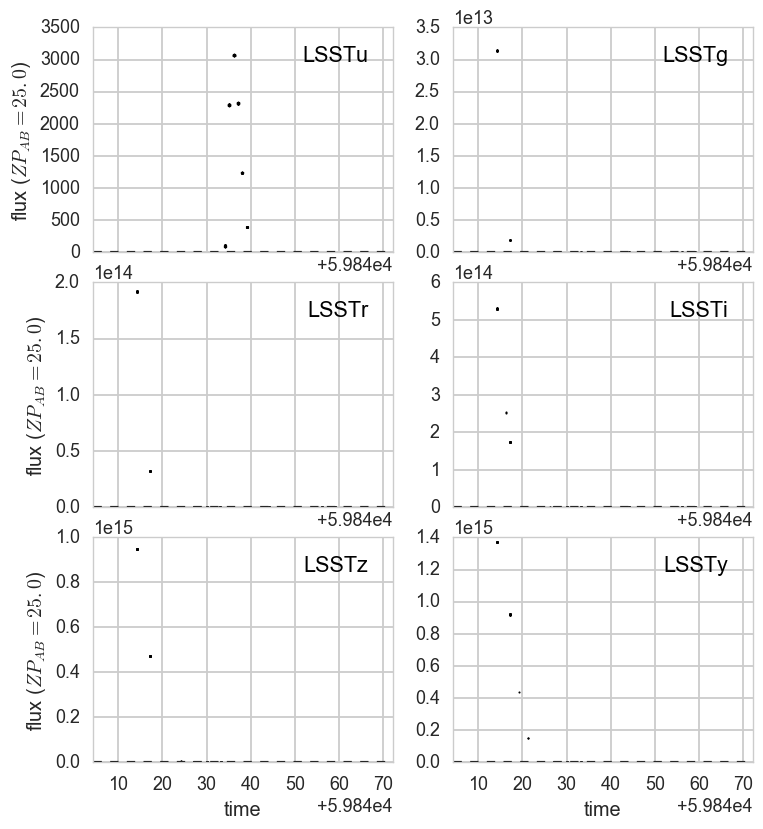

In [56]:
fig_ddf = sncosmo.plot_lc(ddflc.snCosmoLC(), color='k')

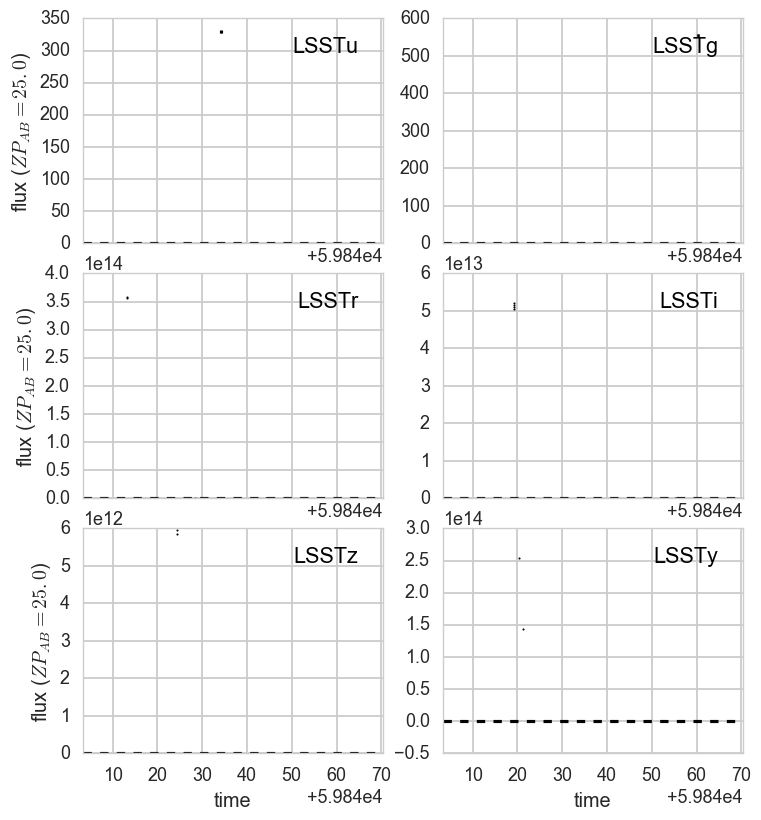

In [57]:
fig_wfd = sncosmo.plot_lc(wfdlc.snCosmoLC(), color='k')

In [58]:
fig_ddf.savefig('ddf_lc.png')
fig_wfd.savefig('wfd_lc.png')